# Lesson 2: Image classification with Convolutional Neural Networks
- Video >> https://www.youtube.com/watch?v=JNxcznsrRb8&t=244s
- wiki >> http://forums.fast.ai/t/wiki-lesson-2/9399
- Lesson notes >> https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-2-eeae2edd2be4

You will learn more about image classification, covering several core deep learning concepts that are necessary to get good performance: what a learning rate is and how to choose a good one, how to vary your learning rate over time, how to improve your model with data augmentation (including test-time augmentation). We also share practical tips (such as training on smaller images), an 8-step process to train a world-class image classifier.

We will start from where we stopped at the end of the first course. We have learnt how to train a Deep Neural Network to classify cats versus dogs. We have reached 97% of accuracy.
But we might not be happy with that. Then how to improve?

we can play with the 3 ingredients we presented before:
- the data
- the architecture
- the opimizer

We have also to pay attention to do not overfit. We saw how to monitore that during the training process in looking to the Loss and accuracy progression. To avoid overfitting, we can:
- Add more data
- Use data augmentation
- Use architectures that generalize well
- Add regularization (dropout)
- Reduce architecture complexity

So, the most important things now to get the model better is to provide more data

## Step 1 to 5: 'Dogs vs Cats' classification task

Here, we import the standard libraries for this lesson.
We will import some other later, but we prefer to do it case by case to understand the need behind

We need the dlutils library provided by Valeo containing useful functions for this lesson. 

You need to upload data_to_upload.tar.gz by clicking
on the left pannel: Files -> upload -> select `data_to_upload.tar.gz` -> open

In [29]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

from pathlib import Path # lib to handle filesystem paths with semantics appropriate for different OS
import matplotlib.pyplot as plt # Matplotlib is a plotting library for the Python but it has also some IO functions
import numpy as np #numpy is the "standard" Python library used to manipulate array and provides mathematical function

import keras # Keras is our Deep Learning framework
from dlutils import unpreprocess, plot_confusion_matrix, create_subdataset

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-6y8wftt8
  Cloning https://github.com/valeoai/dl_utils.git to /tmp/pip-req-build-kyf_f2__
Requirement already up-to-date: imageio in /usr/local/lib/python3.6/dist-packages (2.4.1)
  Running setup.py bdist_wheel for Keras ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2f4sohj/wheels/da/a4/7e/6b7bd9af18cc2e23b8dd5ed6de07a7e13bd80a17214eb88932
  Running setup.py bdist_wheel for dl-utils ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2f4sohj/wheels/71/ad/e4/ef0ed3b20fc1828e7eb4b7fddc4342ae6a7672d62fa2b89c6a
Successfully built Keras dl-utils
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Found existing installation: dl-utils 0.1
    Uninstalling dl-utils-0.1:
      Successfully uninstalled dl-utils-0.1


`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [0]:
import os
if not os.path.isdir('./dogscats/'):
    ! wget http://files.fast.ai/data/dogscats.zip
    ! unzip -q dogscats.zip
PATH = Path("./dogscats/")
if not os.path.isdir('./dogscats/subdataset/'):
    create_subdataset(PATH)

### The Data

In [31]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input

batch_size = 16 # bigger is your memory, bigger the batch size will be
sz = 224

# The path of our training and validation dataset
train_data_dir = PATH/'subdataset/train'
validation_data_dir = PATH/'subdataset/valid'

# Our Image generator does only the transformation defined by the model we are going to use
# preprocess_input belong to "keras.applications.mobilenet", so this is exactly what MobileNet needs!
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# We define our generators below. They will generate batches of images.
# In most of case, they are different but in this case, we use same parameters for both
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(sz, sz),
                                                    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(sz, sz),
                                                        batch_size=batch_size,
                                                       shuffle=False)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### The Model

In [0]:
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D
from keras import optimizers

def make_model():
    # our model is based on MobileNet, but we load only the layers before the classification
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(sz, sz, 3))
    # This loop below is needed to tell to Keras that we don t want to retrain our base model
    for layer in base_model.layers:
            layer.trainable=False

    # below, we define our own layers to perform our binary classification Cats vs. Dogs
    NbClasses = 2
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(NbClasses, activation='softmax', name='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

model = make_model()
sgd = optimizers.SGD(lr=0.01) # we saw in lesson 1 that LR=0.01 was a good choice
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

### The Learning Process

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

Epoch 1/5
250/250 [==============================] - 26s 103ms/step - loss: 0.1928 - acc: 0.9212 - val_loss: 0.0582 - val_acc: 0.9738
Epoch 2/5
250/250 [==============================] - 23s 93ms/step - loss: 0.1151 - acc: 0.9533 - val_loss: 0.0508 - val_acc: 0.9776
Epoch 3/5
250/250 [==============================] - 23s 92ms/step - loss: 0.1031 - acc: 0.9582 - val_loss: 0.0868 - val_acc: 0.9634
Epoch 4/5
250/250 [==============================] - 23s 91ms/step - loss: 0.0925 - acc: 0.9613 - val_loss: 0.0399 - val_acc: 0.9888
Epoch 5/5
250/250 [==============================] - 23s 91ms/step - loss: 0.0865 - acc: 0.9663 - val_loss: 0.0376 - val_acc: 0.9888


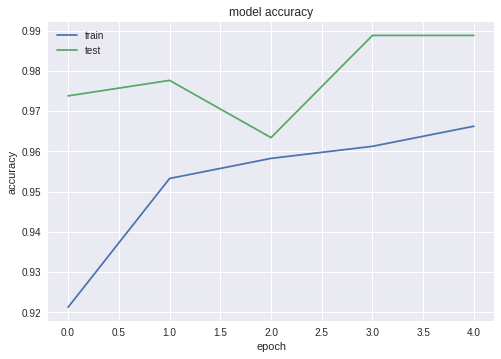

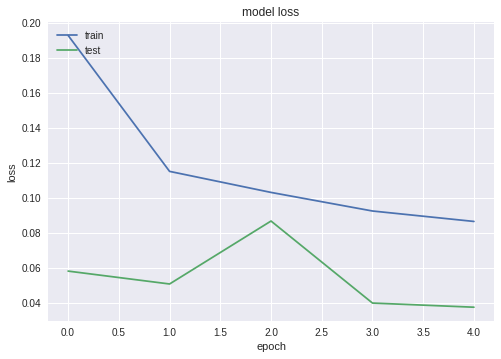

In [34]:
epochs = 5
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              verbose=1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 6- Improving our model

As we have seen, when we try training for more epochs, we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. 
One way to fix this is to provide more data. But, if these data would have been available, it would have been provided from the beginning. 
Pherhaps you notify that the actual size of the Dataset is not only 4656 samples but much more (25k samples). We voluntary used the sample folder instead of the full dataset to be able to run faster and stick with real life constraints.


So, somehow, we have to create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

### Data augmentation

Data augmentation refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating (see [here](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) for a review of existing technics). These basic technics are available in Keras.

Applied to the automotive industry, we can further think to methods that change the color of the object we intend to classify, or apply a kind a filter simulating fog, rain... up to extend the degradation of the sensor through its lifetime!

But for the time being, we will deal with the built-in keras function.
Data augmentation is handled in the <kbd>ImageDataGenerator</kbd> class (see [here](https://keras.io/preprocessing/image/) for more details)

We have used it before to apply transformation on our dataset that was needed by the model we used. We can actually specify a list of transformations that will be applied randomly on each images.

We should take care to apply transformations that only make sense. Indeed, we can apply rotations or flip left/right our images but it would not make any sense to flip top/down our images, right? A dog with the head down would be weird!

Then, such kind of transformation should be applied only on the training set, as we want to validate on real data only.

In [35]:
# Now, our generator can do much more that only preprocessing the picture
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,                             
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.1,
                                   horizontal_flip=True)

# but for the validation set, it does only the preprocessing needed for our model
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# We define our generators below. They will generate batches of images.
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(sz, sz),
                                                    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(sz, sz),
                                                        batch_size=batch_size,
                                                       shuffle=True)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let s have a look to what it does!

In [36]:
# first, to generate a batch of data we have to call
x_batch, y_batch = next(train_generator)

# or
x_batch, y_batch = train_generator.next()

print('not suprising, it will generate as we defined a batch of bs*sz*sz*3 images: ',x_batch.shape)

not suprising, it will generate as we defined a batch of bs*sz*sz*3 images:  (16, 224, 224, 3)


Let's have a look now to what the transformation does

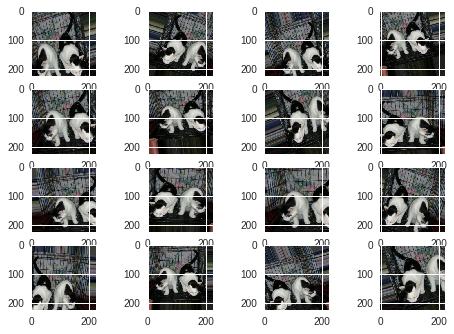

In [37]:
from PIL import Image # use PIL to manipulate images

# take only one image and call several times the DataAugmentation process to check what it does
files = os.listdir(PATH / 'valid/cats')
img = Image.open(PATH / 'valid/cats' / files[0])
img = np.asarray(img.resize((sz, sz)))
x = img.reshape(1, sz, sz, 3)

data_aug_gen = train_datagen.flow(x, [0], 1)

for i in range (0, 4):
    for j in range (0, 4):
        x_batch, y_batch = next(data_aug_gen)
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(unpreprocess(x_batch[0, :, :, :], 'none','tf'))

It is time now to train again our model with more data!

Epoch 1/5
250/250 [==============================] - 70s 279ms/step - loss: 0.1337 - acc: 0.9473 - val_loss: 0.0770 - val_acc: 0.9688
Epoch 2/5
250/250 [==============================] - 68s 271ms/step - loss: 0.1177 - acc: 0.9533 - val_loss: 0.0406 - val_acc: 0.9858
Epoch 3/5
250/250 [==============================] - 68s 271ms/step - loss: 0.1261 - acc: 0.9480 - val_loss: 0.0430 - val_acc: 0.9817
Epoch 4/5
250/250 [==============================] - 68s 271ms/step - loss: 0.1055 - acc: 0.9535 - val_loss: 0.0392 - val_acc: 0.9868
Epoch 5/5
250/250 [==============================] - 68s 271ms/step - loss: 0.1118 - acc: 0.9527 - val_loss: 0.0530 - val_acc: 0.9746


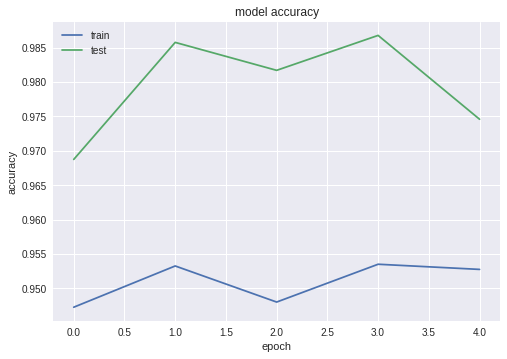

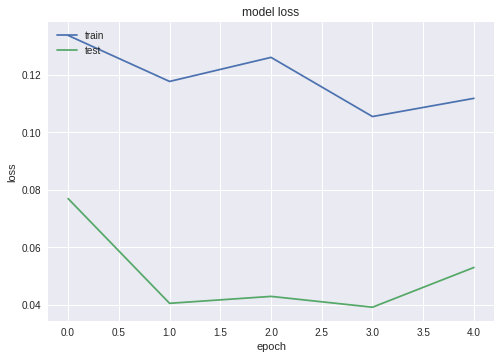

In [38]:
epochs = 5

history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              verbose=1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

By default, when we call our own function <kbd>make_model()</kbd>, it loads the model and adds our own layers to perform our classification task. As we presented during the first lesson, MobileNet has been trained on ImageNet dataset. So, the model and its parameters (weights & bias) have been optimized to provide the best results to classify the 1000 categories of objects on ImageNet.
The process to reuse a pretrained model and apply it to a new task is called <b>Transfer Learning</b> ([here](http://cs231n.github.io/transfer-learning/) for more details, or following 2 blogs [here](https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8) or [here](https://towardsdatascience.com/transfer-learning-946518f95666))

Transfer learning is therefore what we did, using weights & bias learned from ImageNet and applied on Cats & Dogs.
When we create our learner, we have to pay attention to freeze all the parameters except the last classification layer because it is specific to our new problem. That means that it's still only updating the weights in the last layer when we call `fit`. We could load the Classification layer trained on ImageNet but it would be faily not optimal.

We have seen that setting-up the Learning Rate properly is crucial. So far, we have seen the Learning Rate Finder to find the best learning rate <b>in average</b> . There are several optimization algorithm, but the most knwon one is called <b>Stochastic Gradient Descent</b> <kbd>SGD</kbd>. This is what we have used up to now. 

If, for a moment, we put things into perspective, we realize that we want to train as fast as possible and reach the best solution. Remember that the Learning Rate is the step size of our gradient. It therefore sounds obvious to start with big steps to progress as fast as possible AND reduce the step size when we get closer to the solution.

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/LR_step_size.png" width="40%">

This process to adjust the Learning Rate while training is called <b>Learning Rate Annealing</b>. There are different methods of annealing, different ways of decreasing the step size. It is basically all the time the same, it decreases the Learning Rate while training. It can decrease after each iteration, or following a predefined curve such as Linear or Cosine curve:

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/LR_Annealing_1.png" width="40%" title="Decrease by step">
<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/LR_Annealing_2.png" width="40%" title="Linear Decrease">
<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/LR_Annealing_3.png" width="40%" title="Cosine annealing">

However, we may find ourselves in a part of the weight space that isn't very resilient (W1 on picture below) - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. 

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/local_minima.png" width="60%">

Therefore, from time to time we increase the learning rate which will force the model to jump to a different part of the weight space if the current area is "spikey". This technic is called <b>Stochastic Gradient Descent with Restart</b> <kbd>SGDR</kbd>. In that case, the Learning Rate has this kind of shape:

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/SGDR2.png" width="60%">

Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is called *cycle length*, and the number of times this happens is refered to as the *number of cycles*

There are good posts [here](https://towardsdatascience.com/https-medium-com-reina-wang-tw-stochastic-gradient-descent-with-restarts-5f511975163) and [here](https://www.jeremyjordan.me/nn-learning-rate/) that better explain all those technics.

In keras, we use Jeremy Jordan's implementation of [SGDR](https://gist.github.com/jeremyjordan/5a222e04bb78c242f5763ad40626c452)

In [0]:
from dlutils import SGDRScheduler

# we reset everything
model = make_model()
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])

sgdr = SGDRScheduler(min_lr=1e-5,
                     max_lr=1e-2,
                     steps_per_epoch=train_generator.n//train_generator.batch_size,
                     lr_decay=0.8,
                     number_of_cycle = 3,
                     cycle_length = 5,
                     cycle_mult_factor=1.5)

Epoch 1/23
  4/250 [..............................] - ETA: 2:00 - loss: 0.8441 - acc: 0.4531

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: In your callbacks, method `on_batch_end()` is slow compared to a model step (0.163293 vs 0.044550). Check your callbacks.
  % (delta_t_median, self._delta_t_batch))


250/250 [==============================] - 71s 284ms/step - loss: 0.2395 - acc: 0.8947 - val_loss: 0.1181 - val_acc: 0.9476
Epoch 2/23
250/250 [==============================] - 68s 273ms/step - loss: 0.1567 - acc: 0.9355 - val_loss: 0.0587 - val_acc: 0.9776
Epoch 3/23
250/250 [==============================] - 68s 273ms/step - loss: 0.1206 - acc: 0.9522 - val_loss: 0.0581 - val_acc: 0.9827
Epoch 4/23
250/250 [==============================] - 69s 274ms/step - loss: 0.1330 - acc: 0.9450 - val_loss: 0.0643 - val_acc: 0.9787
Epoch 5/23
250/250 [==============================] - 69s 274ms/step - loss: 0.1106 - acc: 0.9540 - val_loss: 0.0624 - val_acc: 0.9797
Epoch 6/23
250/250 [==============================] - 67s 269ms/step - loss: 0.1394 - acc: 0.9415 - val_loss: 0.0868 - val_acc: 0.9614
Epoch 7/23
250/250 [==============================] - 68s 271ms/step - loss: 0.1230 - acc: 0.9480 - val_loss: 0.0600 - val_acc: 0.9787
Epoch 8/23
250/250 [==============================] - 67s 270ms/st

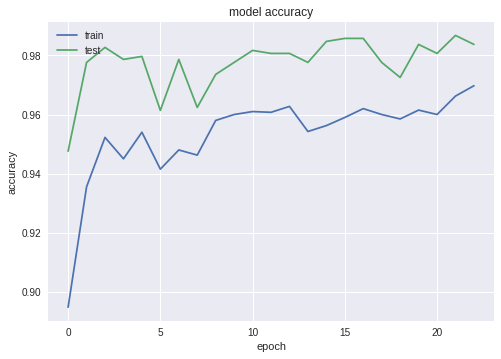

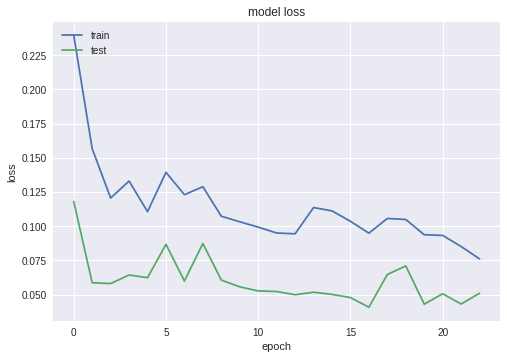

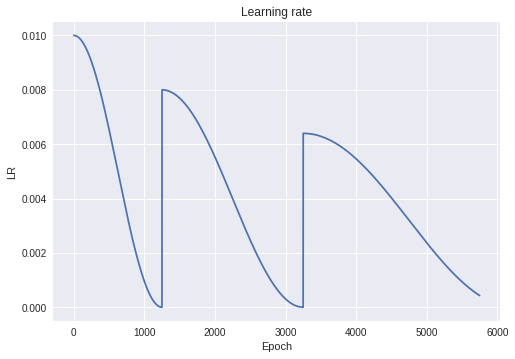

In [40]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=sgdr.nb_epoch,
                              validation_data=validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              verbose=1,
                              callbacks=[sgdr])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for learning rate
plt.plot(sgdr.history['lr'])
plt.title('Learning rate')
plt.ylabel('LR')
plt.xlabel('Epoch')
plt.show()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.



```
# Ce texte est au format code
```

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. In Keras, we have to specify manually which layer we want to freeze or unfreeze.
If we don t know how many layers there are in your model, you can call the function model.summarize()

In [41]:
print(f'our model has {len(model.layers)} layers')

our model has 90 layers


In [0]:
def unfreeze(model, num_layer):
    for layer in model.layers[:num_layer]:
        layer.trainable = False
    for layer in model.layers[num_layer:]:
        layer.trainable = True

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For instance, the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of and this is not <b>available in Keras</b>. So, to make use of it, we have to define ourself the range of layer we want to train at a specific learning rate and repeat it for each range sequentially. Our model has 90 layers, we can  do as following:
- perform a first training as before of the last layer, classfication layer. We have here a million of parameters
- unfreeze from 84 to 90, and put the previously used LR for the fully connected layer --> perform the second training. We have now 2 millions of parameters to train
- unfreeze from 78 to 90, and put initial LR/10 --> perform the third training
- unfreeze from 65 to 90, and put initial LR/100 --> perform the fourth training
- do not unfreeze everything because first layers are basic feature which are supposed to be quite the same across databases. 


In [43]:
model = make_model()

# 1- First training of last layer
LR=0.01
sgd = optimizers.SGD(lr=LR)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
steps_per_epoch = train_generator.n//train_generator.batch_size

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch,
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              verbose=1)

# 2- Second training
unfreeze(model, 84)
sgd = optimizers.SGD(lr=LR)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch,
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              verbose=1)

# 3- Second training
unfreeze(model,78)
LR/=10
sgd = optimizers.SGD(lr=LR)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch,
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              verbose=1)

# 3- Third training
unfreeze(model,65)
LR/=100
sgd = optimizers.SGD(lr=LR) # we saw in lesson 1 that LR=0.01 was a good choice
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch,
                              epochs=5,
                              validation_data=validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              verbose=1)

Epoch 1/3
250/250 [==============================] - 72s 289ms/step - loss: 0.2115 - acc: 0.9123 - val_loss: 0.0899 - val_acc: 0.9688
Epoch 2/3
250/250 [==============================] - 67s 268ms/step - loss: 0.1662 - acc: 0.9348 - val_loss: 0.0715 - val_acc: 0.9705
Epoch 3/3
250/250 [==============================] - 67s 270ms/step - loss: 0.1227 - acc: 0.9493 - val_loss: 0.0606 - val_acc: 0.9807
Epoch 1/3
250/250 [==============================] - 72s 289ms/step - loss: 0.1288 - acc: 0.9462 - val_loss: 0.0756 - val_acc: 0.9677
Epoch 2/3
250/250 [==============================] - 68s 272ms/step - loss: 0.1242 - acc: 0.9530 - val_loss: 0.0756 - val_acc: 0.9715
Epoch 3/3
250/250 [==============================] - 69s 274ms/step - loss: 0.1092 - acc: 0.9572 - val_loss: 0.0397 - val_acc: 0.9848
Epoch 1/3
250/250 [==============================] - 72s 290ms/step - loss: 0.0832 - acc: 0.9690 - val_loss: 0.0405 - val_acc: 0.9829
Epoch 2/3
250/250 [==============================] - 69s 274ms

## Analyzing results

### Confusion matrix 
A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

Confusion matrix, without normalization
[[242 258]
 [259 241]]


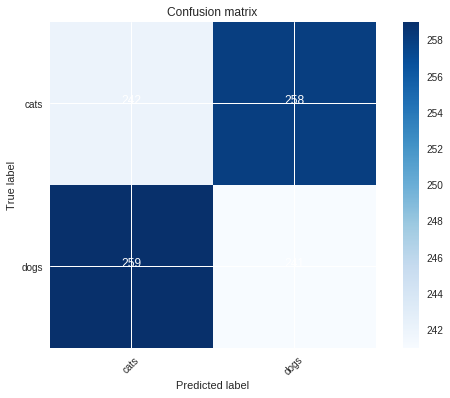

In [44]:
proba = model.predict_generator(validation_generator)
preds = np.argmax(proba, axis=1)
probs = np.amax(proba, axis=1)
plot_confusion_matrix(validation_generator.classes, preds, ["cats","dogs"])

## Review: easy steps to train a world-class image classifier

1. Use `Learning_rate_finder()` to find highest learning rate where loss is still clearly improving
1. Train last layer for 1-2 epochs
1. Train last layer with data augmentation for 2-3 epochs
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `Learning_rate_finder()` again
1. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

Let's look at the Dogs v Cats code line by line.

The `ImageDataGenerator` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and plenty of other transformation to perform Data Augmentation.

The `flow_from_directory` reads data from a provided path and creates a dataset ready for training. It actually create a subset of the training sample to fit into memory

`make_model` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/02_Classification_improvements/pretrained.png" width="60%">

*Parameters*  are learned by fitting a model to the data. *Hyperparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

## Analyzing results: loss and accuracy

When we run `model.fit` or `model.fit_generator` we print 4 performance values (see before). First, there is the value of the **loss** in the training set, then, the value of the **accuray** in the training set, the value again of the **loss** in the validation set and the value of the **accuracy** in the validation set. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.


**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

# What did we learn?

We learn today how to classify dogs from cats. Rather than understanding the mathematical details of how this works, we start by learning the nuts and bolts of how to get the computer to complete the task, using ‘fine-tuning’, perhaps the most important skill for any deep learning practitioner. In a later lesson we’ll learn about how fine-tuning actually works “behind the scenes”.

# Assignment

- Select a dataset from Kaggle and apply everything you have learnt today on it
- provide a notebook with comments and explain why you selected these parameters, put things into perspective to explain performances

# END